In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.21.5
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
x_columns = ['v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos',]

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_cat']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_cat']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_cat']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)


['/test', '/train', '/valid']
(63311, 11)
(63311,)


In [ ]:
valid_y

In [3]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
valid_x_scaled = scaler.fit_transform(valid_x)
test_x_scaled = scaler.fit_transform(test_x)

In [4]:
print(np.max(train_x_scaled), np.min(train_x_scaled))

6.4529692627123 -6.060409669500032


In [5]:
train_x_scaled

array([[-0.77730431, -0.78538985, -0.681154  , ..., -0.87874502,
         1.247682  , -1.22375194],
       [-0.49826761, -0.44862029, -1.40507479, ..., -0.07390625,
        -0.85802556, -1.22375194],
       [ 1.42379882,  1.29260154,  1.05573476, ..., -2.03012251,
        -0.85802556, -1.22375194],
       ...,
       [ 0.793058  ,  0.76798605,  0.15200075, ..., -1.2489984 ,
        -1.29413188, -0.22902426],
       [-1.54543334, -1.60561773, -2.33698241, ...,  0.89902726,
         1.68378831, -0.22902426],
       [-0.34942302, -0.30821825, -0.40831392, ...,  1.00111465,
         1.68378831, -0.22902426]])

In [15]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[11, ]))
for _ in range(16):
    model.add(keras.layers.Dense(20, activation="selu"))
for _ in range(4):
    model.add(keras.layers.Dense(20, activation="selu"))
    model.add(keras.layers.AlphaDropout(rate=0.5))
# AlphaDropout: 1. 均值和方差不变 2. 归一化性质也不变
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(3, activation="softmax"))

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[11,]),
#     keras.layers.Dense(9, activation='relu'),
#     keras.layers.Dense(6, activation='relu'),
#     keras.layers.Dense(3, activation='softmax')
# ])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [7]:
model.layers

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 11)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               1200      
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [ ]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [16]:
# H:/github/python/seafog/
logdir = './callbacks_class_dnn_selu_dropout'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_classi_dnn_selu_dropout_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    # keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    # keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
    ]
history = model.fit(train_x_scaled, train_y, epochs=100,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/100
1979/1979 [==============================] - 12s 6ms/step - loss: 1.4331 - accuracy: 0.3432 - val_loss: 1.1600 - val_accuracy: 0.5716
Epoch 2/100
1979/1979 [==============================] - 10s 5ms/step - loss: 1.2072 - accuracy: 0.3618 - val_loss: 0.9853 - val_accuracy: 0.6356
Epoch 3/100
1979/1979 [==============================] - 10s 5ms/step - loss: 1.1194 - accuracy: 0.3803 - val_loss: 0.9428 - val_accuracy: 0.6361
Epoch 4/100
1979/1979 [==============================] - 10s 5ms/step - loss: 1.0869 - accuracy: 0.4026 - val_loss: 0.9569 - val_accuracy: 0.6376
Epoch 5/100
1979/1979 [==============================] - 10s 5ms/step - loss: 1.0682 - accuracy: 0.4224 - val_loss: 1.0313 - val_accuracy: 0.6400
Epoch 6/100
1979/1979 [==============================] - 10s 5ms/step - loss: 1.0559 - accuracy: 0.4390 - val_loss: 1.1698 - val_accuracy: 0.6448
Epoch 7/100
1979/1979 [==============================] - 10s 5ms/step - loss: 1.0428 - accuracy: 0.4518 - val_loss: 1.3850 -

KeyboardInterrupt: 

In [ ]:
type(history)

In [ ]:
history.history

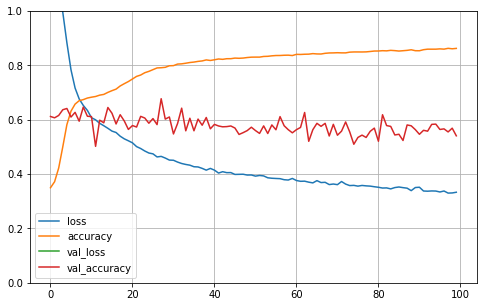

In [13]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [14]:
model.evaluate(test_x_scaled, test_y, verbose=0)

[15.821459770202637, 0.561163604259491]

In [ ]:
predictions = model(test_x_scaled).numpy()
predictions

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()



In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 